# Final Assignment: Suicide Text Classification

According to the [World Health Organization](https://www.who.int/health-topics/suicide#tab=tab_1), over 700,000 people die by suicide annually worldwide, and for each suicide death, more than 20 suicide attempts are made. Suicides and suicide attempts create ripple affects to close families, friends and communities, making the prevention of attempts vital. Detection of attempts before they occur could save numerous lives, and help prevent the large tolls that attempts take on both the individual, and those around them.

For this project, my aim was to leverage machine learning to detect suicidal thought, and assess multiple models and their ability to detect thought. The dataset I used was taken from this [Kaggle dataset](https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch?select=Suicide_Detection.csv), which is a collection of text posts scraped from 2 different subreddits called "SuicideWatch" and "depression". All posts that were made to "SuicideWatch" from December 16, 2008 (creation of the subreddit) until January 2, 2021, were collected while "depression" posts were collected from January 1, 2009, to January 2, 2021. 

In this dataset, posts that are collected from the SuicideWatch subreddit were categorized as suicidal, while those from the depression subreddit were categorized as non-suicidal. The intuition behind this is that texts from either subreddit would be closer in general tone and vocabulary than a random text scraped from another subreddit. This makes the task more difficult, but also gives credit to the classification ability of our machine learning methods, as they are able to distinguish texts indicating suicidal ideation from those indicative of generally poor mental health/state.

In [25]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neattext.functions as nfx
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, accuracy_score,plot_roc_curve, confusion_matrix
from sklearn.metrics import mean_squared_error, precision_recall_curve, auc, accuracy_score
from tqdm import tqdm
warnings.filterwarnings('ignore')

## Data and Pre-Processing

The dataset consists of a .csv that contains both the text from each post, and the classification of that post as either suicidal or non-suicidal. To convert the data into a format that can be taken in by the model, I convert each text post into what I've dubbed a "frequency vector". This is a vector where each index represents a different word, and where the value of the i-th element is the number of times that the i-th word has been detected in the text. This is a simple method that encodes the frequency of each word. 

In order to avoid low-frequency words (as these may be words that are typos, and/or only pop up in a handful of texts and therefore may be situation-specific) I filter for the 10,000 words with the highest frequency in the training set. My final input for each sample is thus a 10,000 element vector, containing the frequency of each of the 10,000 words. After sampling 30% of the full data (due to memory limitations), I use a 60/40 split to allocate training and testing data, respectively. I then encode the label of each sample as 1 (or True) to indicate a post showing suicidal ideation, and 0 (or False) to indicate a post not showing suicidal ideation.

### Reading data

In [9]:
#Load in data
data = pd.read_csv('Suicide_Detection.csv',index_col=0)
#Due to memory limitations, I can only sample for 30% of the full data.
data = data.sample(frac=0.3,random_state=10)
train_data,test_data=train_test_split(data,test_size=0.4,random_state=10)

In [10]:
data.loc[data['class']=="non-suicide",].head(3)

,text,class
37204,ANYBODY WHO CAN PHOTO SHOP(simply cropping out...,non-suicide
30955,question to my fellow asian-americans &amp; fi...,non-suicide
231290,Merry Christmas &lt;3,non-suicide


Above is an example of how the dataset is stored in the dataframe. The class column contains either "suicide" or "non-suicide" label, and the text column contains a string of text that has been scraped. In order to increase consistency between different pieces of texts, I convert the text to all lower case, and remove any stop words (common words like: as, for, with). This is shown in the clean_text() function below.

In [11]:
def clean_text(text):
    #Function for cleaning multiple pieces of text
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent) #This function removes special characters from the text
        sent=nfx.remove_stopwords(sent) #This function removes stop words from the text
        cleaned_text.append(sent)
    return cleaned_text #Return cleaned word in the text

In [12]:
train_data['class'].value_counts()

non-suicide    21011
suicide        20762
Name: class, dtype: int64

As you can see, there is a good balance in our training data between positive and negative cases.

In [13]:
#Cleaning training and testing data
cleaned_train_text=clean_text(train_data.text)
cleaned_test_text=clean_text(test_data.text)

#Converting data into useable format
t = Tokenizer(num_words=10000)
t.fit_on_texts(cleaned_train_text) 
X_train = t.texts_to_matrix(cleaned_train_text, mode='count') #Converts multiple text samples into a matrix 
X_test = t.texts_to_matrix(cleaned_test_text, mode='count')

#Normalize and scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Binarizing text labels into number format for classification
y_train=train_data['class']=='suicide'
y_train=y_train.to_numpy()
y_test=test_data['class']=='suicide'
y_test=y_test.to_numpy()


100%|█████████████████████████████████████████████████████████████████████████| 27849/27849 [00:01<00:00, 20477.23it/s]


The Tokenizer class is a keras class that can convert texts into formats for NLP usage. In this case, the Tokenizer class determines the frequency of each word in each sample, returning a NxP matrix where N is the number of samples and P is the number of words. The Nth,Pth element of the matrix is thus the frequency that the Pth word occurs in sample N. The num_words argument is used so that the Tokenizer will only take the most 10,000 frequently occuring words. 

The feature data thus consists of an NxP frequency matrix, that has been Z-score normalized, and the label data consists of a 0 or 1, where 1 denotes a case of possible suicidal ideation, and 0 denotes a non-suicidal text. 

## Model Training

Now that we have our formatted data, we can begin to test different models. For this assignment, I wanted to test Random Forests, Logistic Regression, and a neural network model and compare their performance. For the Logistic Regression and Random Forest models, I use the built-in sklearn classes, while for the neural network I use a dense neural network with 4 layers and one final sigmoid activation layer.

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

I train my Random Forests model with a max depth of 2, to limit the degree of overfitting.

In [15]:
from sklearn.linear_model import SGDClassifier
LR = SGDClassifier(max_iter=1000, tol=1e-3,loss='log',penalty='elasticnet')
LR.fit(X_train,y_train)

SGDClassifier(loss='log', penalty='elasticnet')

For the logistic regression model, I use the SGDClassifier class with the 'log' loss, which gives a logistic regression model that can predict probabilities. I also use elastic-net regularization for my model, which is a type of regularization that combines both L1 and L2 regularization in regression models. 

In [16]:
#Build deep neural network using stochastic gradient decscent and 4 dense, fully-connected layers 
opt = tf.keras.optimizers.SGD(learning_rate=0.005)
DNN = tf.keras.Sequential()
DNN.add(tf.keras.layers.Dense(2000, input_shape=(10000,)))
DNN.add(tf.keras.layers.Dense(500))
DNN.add(tf.keras.layers.Dense(125))
DNN.add(tf.keras.layers.Dense(1,activation='sigmoid')) #Final layer uses sigmoid activation for binary classification
DNN.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
#Model training
history=DNN.fit(X_train, y_train,
              epochs=10,
              batch_size=128,
              validation_split=0.2)

Epoch 1/10
262/262 [==============================] - 23s 87ms/step - loss: 0.4740 - accuracy: 0.8021 - val_loss: 0.3465 - val_accuracy: 0.8612
Epoch 2/10
262/262 [==============================] - 22s 86ms/step - loss: 0.2446 - accuracy: 0.9054 - val_loss: 0.3088 - val_accuracy: 0.8840
Epoch 3/10
262/262 [==============================] - 23s 86ms/step - loss: 0.1883 - accuracy: 0.9309 - val_loss: 0.3050 - val_accuracy: 0.8930
Epoch 4/10
262/262 [==============================] - 22s 85ms/step - loss: 0.1567 - accuracy: 0.9435 - val_loss: 0.3145 - val_accuracy: 0.8940
Epoch 5/10
262/262 [==============================] - 22s 85ms/step - loss: 0.1354 - accuracy: 0.9510 - val_loss: 0.3323 - val_accuracy: 0.8973
Epoch 6/10
262/262 [==============================] - 23s 87ms/step - loss: 0.1193 - accuracy: 0.9573 - val_loss: 0.3475 - val_accuracy: 0.8975
Epoch 7/10
262/262 [==============================] - 22s 85ms/step - loss: 0.1064 - accuracy: 0.9621 - val_loss: 0.3703 - val_accuracy:

For the deep neural network model, I built my network using 4 fully connected layers and a final sigmoid activation layer. I also used a binary cross entropy loss, and tracked both the validation and training loss and accuracy using a validation split of 20%. The model was trained over 10 epochs and a batch size of 256.

In [18]:
#Reformatting data for plotting purposes using seaborn
history_df = pd.DataFrame(history.history)
history_df['Epoch']=history_df.index+1
loss_df=pd.melt(history_df[['loss','Epoch','val_loss']],id_vars='Epoch',value_name='Loss')
accuracy_df=pd.melt(history_df[['accuracy','Epoch','val_accuracy']],id_vars='Epoch',value_name='Accuracy')

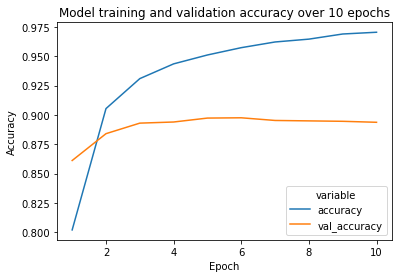

In [19]:
p=sns.lineplot(data=accuracy_df,x='Epoch',y='Accuracy',hue='variable')
_=p.set(title="Model training and validation accuracy over 10 epochs")

The above plot shows the training and validation accuracy for the model over the course of 10 epochs. The validation accuracy and training accuracy remain about the same until after the 2nd epoch, after which the model's training accuracy overtakes the validation accuracy, and the model begins to overfit to the training set. 

<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

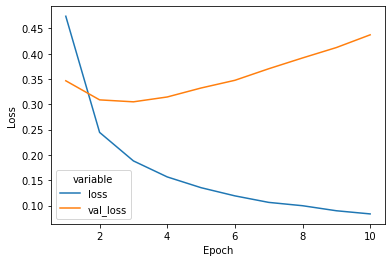

In [20]:
sns.lineplot(data=loss_df,x='Epoch',y='Loss',hue='variable')

The above plot shows the training and validation binary cross-entropy loss for the model over the course of 10 epochs. The validation accuracy and training accuracy remain about the same until after the 2th epoch, after which the model's training loss overtakes the validation loss. The above 2 plots are good indications that the model begins to overfit after the 5th epoch, and continuing to fit the data is redundant at that point.  

## Model Evaluation

In [57]:
y_pred=DNN.predict(X_test)
auc = roc_auc_score(y_test,y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred>0.5).ravel()
sensitivity = tp / (tp+fn)
NPV = tn/(tn+fn)
accuracy = accuracy_score(y_test,y_pred>0.5)

DNN_metrics=['DNN',accuracy,auc,sensitivity,NPV]

In [58]:
y_pred=LR.predict(X_test)
auc = roc_auc_score(y_test,y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred>0.5).ravel()
sensitivity = tn / (tn+fp)
NPV = tn/(tn+fn)
accuracy = accuracy_score(y_test,y_pred>0.5)

LR_metrics=['LR',accuracy,auc,sensitivity,NPV]

In [59]:
y_pred=rf.predict(X_test)
auc = roc_auc_score(y_test,y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred>0.5).ravel()
sensitivity = tn / (tn+fp)
NPV = tn/(tn+fn)
accuracy = accuracy_score(y_test,y_pred>0.5)
RF_metrics=['RF',accuracy,auc,sensitivity,NPV]

In [60]:
results_df=pd.DataFrame([DNN_metrics,LR_metrics,RF_metrics],columns=['Model','Accuracy','AUROC','Sensitivity','Negative Predictive Value'])

The metrics I used to assess the performance of my models include accuracy, specificity, negative predictive value, and area under the receiver-operator curve (AUROC). Accuracy and AUROC are both standard metrics used to assess model performance in a binary classification setting. However, I also decided to assess sensitivity and negative predictive value, since having false negative in this case could mean a lost suicide attempt, and is therefore a priority to avoid.

<Figure size 576x1152 with 0 Axes>

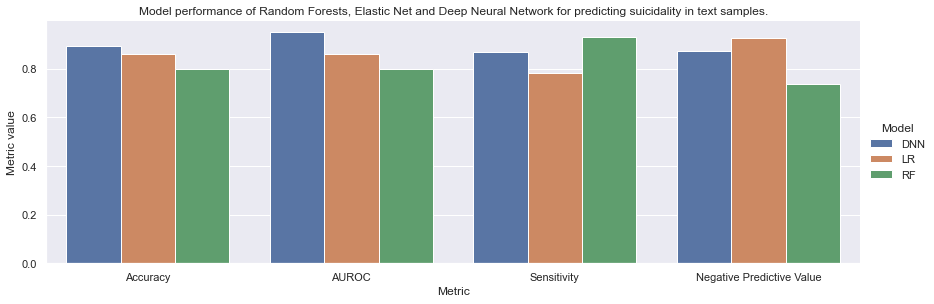

In [62]:
melted_df=pd.melt(results_df,id_vars="Model")
sns.set(style="darkgrid")
plt.figure(figsize=(8, 16))
p=sns.catplot(x="variable", y="value",
                 hue="Model", 
                 data=melted_df, kind="bar",
                 height=4, aspect=3.0);
_=p.set(title="Model performance of Random Forests, Elastic Net and Deep Neural Network for predicting suicidality in text samples.",
       xlabel="Metric",ylabel="Metric value")

Based on the above results, it seems like the best method differs depending on the metric used. While the deep neural network performed best in terms of accuracy and AUROC, when taking into account the importance of sensitivity and negative predictive value, the DNN falls behind other methods. For example, logistic regression has the highest negative predictive value, while random forests has the highest sensitivity. Thus, it is difficult to say which model is necessarily the best as no model seems to totally outclass the others, and each model has metrics where it performs well. Given the importance of preventing false negatives, I would argue that maximizing negative predictive value should be the most import indicator of the model's performance. with respect to this metric, the logistic regression model performs the best for this task.

Overall, all models perform well in their ability to classify the texts. There could be a number of improvements to this project however. Firstly, the data scraped was simply taken from both subreddits, and not screened nor classified with any systematic rigor. As a result, there may have been some cases where an individual in the depression subreddit expressed suicidal ideation and that text was misclassified, or vice versa. Additionally, the feature engineering was relatively simple (just counting the frequency of words), and there many other ways of encoding text that could be explored. Finally, the models used here are relatively simple, and there are other architectures that could have been used such as RNNs, or autoencoders, that are more complex and may perform better.